# Average Mode

The script demonstrates the use of average mode. The first sections connects & configures the system 
and sets the waveform generator. The latter sections define the average mode setting & digitizer sampling operation. 
The generator is configured on Channel-1, the signal is defined through a task table which consists of single cycle of "sin" wave followed by a "dc" quiet time.
An additional marker is defined on Marker-1 of channel 1 - currently in the half time of the active signal.

The digitizer is also configured on the input channel-1, so some loopback is required for the testing.
Starting from section: 'Average Mode Parameters', the average mode setting are defined 
and consists of the following:

#### Average Count up 1-16M
AvgCount=8000000
#### Frame Size 1-10240
frame_size = 9600 
####  number_of_frames =1 : Should be fixed one.

In order to repeat tests with different parameters, you only need to replay sections starting from section: 'Average Mode Parameters'.
A background parameter called the AverageMSBShift - is set to be the log2 of the AvgCount parameter since the summing accumlators are limted to 36 bit. 

The resulting data is displayed in a "raw" & normalized forms at the end.




In [1]:
import os
import sys
import gc
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from tevisainst import TEVisaInst

In [2]:
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt


In [3]:
# Connect to instrument

inst = None
admin = None

conn_msg_str = ''

def disconnect():
    global inst
    global admin
    if inst is not None:
        try:
            inst.close_instrument()            
        except:
            pass
        inst = None
    if admin is not None:
        try:
            admin.close_inst_admin()
        except:
            pass
        admin = None
    gc.collect()

def connect_to_pxi_slot(slot_id):
    global inst
    global admin
    try:
        disconnect()        
        print("Trying to connect to PXI-slot:" + str(slot_id))
        admin = TepAdmin() #lib_dir_path= lib_dir_path_)
        admin.open_inst_admin()        
        inst = admin.open_instrument(slot_id, reset_hot_flag=True)
    except:
        pass

def connect_to_lan_server(ip_address):
    global inst
    try:
        disconnect()
        print("Trying to connect to IP:" + ip_address)
        inst = TEVisaInst(ip_address, port=5025)
    except:
        pass

def connect(ipaddr_or_slotid):
    try:
        disconnect()
        if isinstance(ipaddr_or_slotid, str) and '.' in ipaddr_or_slotid:
            connect_to_lan_server(ipaddr_or_slotid)
        else:
            connect_to_pxi_slot(ipaddr_or_slotid)
    except:
        pass

addr_textbox = widgets.Text(
    value='',
    placeholder='IP Address or Slot Id',
    description='Address:',
    disabled=False
)

output = widgets.Output()

def print_conn_message(msg_str):
    global output
    global conn_msg_str
    with output:
        if len(conn_msg_str) > 0:
            print('\r', end='')
            print(' ' * len(conn_msg_str), end='')
            print('\r', end='')
        conn_msg_str = str(msg_str)
        if len(conn_msg_str) > 0:
            print(conn_msg_str, end='')

def on_button_connect_clicked(conn_str):
    global inst
    global addr_textbox
    print_conn_message('')
    disconnect()
    if addr_textbox is not None:
        conn_str = addr_textbox.value 
        if conn_str:
            print_conn_message('Connecting to {0} ..'.format(conn_str))
            connect(conn_str)
            print_conn_message('')
    if inst is not None:
        idn_str = inst.send_scpi_query('*IDN?')
        model = inst.send_scpi_query(":SYST:iNF:MODel?")
        if idn_str:
            prnmsg = 'Connected to: ' + idn_str.strip()
            print_conn_message(prnmsg)
            #print_conn_message('Connected to: ' + idn_str.strip())
            
    else:
        print_conn_message('Instrument not connected..')
    


In [4]:
connect("192.168.0.117")



if inst is not None:
        idn_str = inst.send_scpi_query('*IDN?')
        model = inst.send_scpi_query(":SYST:iNF:MODel?")
        if idn_str:
            prnmsg = 'Connected to: ' + idn_str.strip()
            print(prnmsg)
else:
    print("Not connected")

pid = os.getpid()
print('process id {0}'.format(pid))

inst.send_scpi_cmd(':TRAC:DEL:ALL')
paranoia_level =2

model = inst.send_scpi_query(":SYST:iNF:MODel?")
print("\nModel: " + model)
# Infer the natural DAC waveform format
if 'P9082' in model:
    dac_mode = 8
else:
    dac_mode = 16
print("DAC waveform format: {0} bits-per-point".format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0

freq = 8640e6
inst.send_scpi_cmd("*CLS; *RST")
inst.send_scpi_cmd(":INST:CHAN 1")
inst.send_scpi_cmd(":FREQ:RAST {0}".format(freq))
inst.send_scpi_cmd(":INIT:CONT ON")

    
print(dac_mode)

Trying to connect to IP:192.168.0.117
Connected to: Tabor Electronics,P9484M,000000000000,1.223.0
process id 18420

Model: P9484M
DAC waveform format: 16 bits-per-point
16


In [5]:


resp = inst.send_scpi_query(":FREQ:RAST?")
freq = float(resp)
print ("DAC Generate Freq:{0}".format(freq))
freq= 8640e6

DAC Generate Freq:8640000000.0


## DC - Waveform 1 (Task 1)

2
0, no error


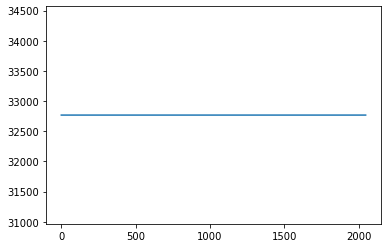

In [6]:
cycleLen = 2048
numCycles = 1
segLen = cycleLen * numCycles

# Build waveform (triangle wave)
y = np.ones(segLen)* half_dac
y = y.astype(data_type)
y.reshape(-1)

print(y.itemsize)
# Set Data as Task 1
#inst.send_scpi_cmd(':TRAC:DEF 1, {0}'.format(segLen*y.itemsize))
inst.send_scpi_cmd(':TRAC:DEF 1, {0}'.format(segLen)) #*y.itemsize))
inst.send_scpi_cmd(':TRAC:SEL 1')
# download the waveform to the selected Task
inst.write_binary_data(':TRAC:DATA', y)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

plt.plot(y)


## Signal Marker 1

In [7]:
print('Build marker-data for sinus wave (segment 2) and download it to Proteus device.')

seg_mark_bytes = 0

#Temp workaround : in high freq over 2.5GHz work like 8 bit
if dac_mode == 16 and freq<= 2500000000:
    seg_mark_bytes = segLen // 4
else:
    seg_mark_bytes = segLen // 8
    
print (segLen)
print("Seg marker bytes:" + str(seg_mark_bytes))
y = np.zeros(seg_mark_bytes)
marker = y.astype(np.uint8)
    
inst.send_scpi_cmd(":INST:CHAN 1")    
inst.send_scpi_cmd( ":TRAC:SEL 1", paranoia_level)    
inst.send_scpi_cmd(':MARK:SEL 1')
inst.write_binary_data(':MARK:DATA',marker)
inst.send_scpi_cmd(':MARK:STAT ON')

    
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


Build marker-data for sinus wave (segment 2) and download it to Proteus device.
2048
Seg marker bytes:256
0, no error


## Signal Waveform-2 (Task 2)

Build wave-data and download it to Proteus device.
0, no error


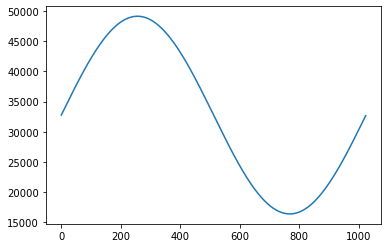

In [8]:
print('Build wave-data and download it to Proteus device.')
# Build two AWG segment that will be used as innput for the digitizer
paranoia_level = 2
cycleLen = 1024
numCycles = 1
segLen = cycleLen * numCycles

# Build sine waveform

x = np.linspace(
    start=0, stop=2 * np.pi * numCycles, num=segLen, endpoint=False)
y = (0.5*np.sin(x) + 1.0) * half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)
y.reshape(-1)
# Download it to segment 1 of channel 1
#inst.send_scpi_cmd( ":TRAC:DEF 2," + str(segLen*y.itemsize), paranoia_level)
inst.send_scpi_cmd( ":TRAC:DEF 2," + str(segLen), paranoia_level)
inst.send_scpi_cmd( ":TRAC:SEL 2", paranoia_level)

inst.write_binary_data(':TRAC:DATA',y)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

plt.plot(y)

##### Signal Marker 2

In [9]:
print('Build marker-data for sinus wave (segment 2) and download it to Proteus device.')

seg_mark_bytes = 0
#Temp workaround : in high freq over 2.5GHz work like 8 bit
if False: #dac_mode == 16:
    seg_mark_bytes = segLen * 2 //8
    cycleBytes = cycleLen //4
else:
    seg_mark_bytes = segLen // 8
    cycleBytes = cycleLen //8


x = np.linspace(start=0, stop=seg_mark_bytes, num=seg_mark_bytes, endpoint=False)
y = np.fmod(x, cycleBytes)
y = (y > cycleBytes / 2) * 0x11   #Duty cycle condition:cycleBytes / 2
y = np.round(y)
y = np.clip(y, 0, 255)
marker = y.astype(np.uint8)
    
inst.send_scpi_cmd(":INST:CHAN 1")    
inst.send_scpi_cmd( ":TRAC:SEL 2", paranoia_level)    
inst.send_scpi_cmd(':MARK:SEL 1')
inst.write_binary_data(':MARK:DATA',marker)
inst.send_scpi_cmd(':MARK:STAT ON')

    
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


Build marker-data for sinus wave (segment 2) and download it to Proteus device.
0, no error


## Configure Tasks

In [10]:
tak_half_dac = 0x80

inst.send_scpi_cmd(':INST:CHAN 1')          # Select channel
inst.send_scpi_cmd(':TASK:COMP:LENG 3')     # Set 4 Tasks in this Task Table


inst.send_scpi_cmd(':TASK:COMP:ENAB CPU')    # CPU trigger is the task enable
inst.send_scpi_cmd(':TASK:COMP:SEGM 1')      # play segment 1 (DC)
inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV {0}'.format(tak_half_dac))  # DC level while waiting to a trigger
inst.send_scpi_cmd(':TASK:COMP:NEXT1 2')     # the next task is 2     
    
inst.send_scpi_cmd(':TASK:COMP:SEL 2')
inst.send_scpi_cmd(':TASK:COMP:ENAB NONE')    # NONE trigger is the task enable
inst.send_scpi_cmd(':TASK:COMP:SEGM 2' )       # play segment 2 (Signal)
inst.send_scpi_cmd(':TASK:COMP:TYPE START' )
inst.send_scpi_cmd(':TASK:COMP:SEQ 1000000') # sequence loop = AvgCount or other
inst.send_scpi_cmd(':TASK:COMP:DTRigger ON')   # issue a trigger to the ADC at start of segment
inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV {0}'.format(tak_half_dac))  # DC level while waiting to a trigger
inst.send_scpi_cmd(':TASK:COMP:LOOP 1' )       # repeat the segment 1 time
inst.send_scpi_cmd(':TASK:COMP:NEXT1 3')       # the next task is 3

inst.send_scpi_cmd(':TASK:COMP:SEL 3')
inst.send_scpi_cmd(':TASK:COMP:ENAB NONE')    # NONE trigger is the task enable
inst.send_scpi_cmd(':TASK:COMP:SEGM 1' )       # play segment 1 (DC)
inst.send_scpi_cmd(':TASK:COMP:TYPE END' )
inst.send_scpi_cmd(':TASK:COMP:LOOP 20' )       # repeat the segment 1 time
inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV {0}'.format(tak_half_dac))  # DC level while waiting to a trigger
#inst.send_scpi_cmd(':TASK:COMP:DTRigger ON')   # issue a trigger to the ADC at start of segment
inst.send_scpi_cmd(':TASK:COMP:NEXT1 1')       # the next task is 1
    
inst.send_scpi_cmd(':TASK:COMP:WRIT' )   
print('Downloading Task table of channel 1')

 

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


# Start Channel 1 at Task mode

In [11]:
# Enable channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':SOUR:VOLT 0.2')

# Set Channel 1 to run task function
inst.send_scpi_cmd('FUNC:MODE TASK')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
inst.send_scpi_cmd(':OUTP ON')

0, no error


0

In [12]:

## Test generatation of  1 M signal events.
inst.send_scpi_cmd('*TRG')

0

# Average Mode Parameters 

In [13]:
#Digitizer Average Mode Settings 
##################################
#Average Count up 1-16M
AvgCount=1000000
##################################
#Frame Size 1-10240
frame_size = 9800

##################################
number_of_frames =1 # Should be fixed one.


# Setup Digitizer

In [14]:
## New Average Mode registers:
inst.send_scpi_cmd(':DIG:ACQuire:AVERage:STAT ON')
inst.send_scpi_cmd(':DIG:ACQuire:AVERage:COUNt {0}'.format(AvgCount))

# Erase previous capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:ACQuire:ZERO 1,-1')

print("Set Digitizer: SINGLE mode; internal Trigger")
inst.send_scpi_cmd(':DIG:MODE SINGLE')
inst.send_scpi_cmd(':DIG:FREQ 5400MHZ')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

inst.send_scpi_cmd(':DIG:ACQuire:FRAM:DEF {0}, {1}'.format(number_of_frames, frame_size))
inst.send_scpi_cmd(':DIG:ACQuire:FRAM:CAPT 1, 1')

# Set Trigger level to 0.2V
#inst.send_scpi_cmd(':DIG:TRIG:LEV1 -0.1')

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1') 


# Enable capturing data from channel 2
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')


inst.send_scpi_cmd(':DIG:TRIG:AWG:TDEL 0.0')



Set Digitizer: SINGLE mode; internal Trigger
0, no error


0

In [15]:
resp = inst.send_scpi_query(':DIG:MODE?')
print("Digitizer Mode:"+resp)

resp = inst.send_scpi_query(':DIG:ACQuire:AVERage:STAT?')
print("Average Mode:"+resp)
if resp in "ON":
    datatype = np.uint32
else:
    datatype = np.uint16
    
resp = inst.send_scpi_query(':DIG:ACQuire:AVERage:COUNt?')
print("Average Count:"+resp)

resp = inst.send_scpi_query(':SHELL:REG? 0x004060AC') 
print("Avg Sum shift:"+resp)
AvgShiftMSB = resp

resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:DEF?') 
print ("Frame size:"+ str(frame_size))
print(resp[2:])


Digitizer Mode:SING
Average Mode:ON
Average Count:1000000
Avg Sum shift:0x00000008
Frame size:9800
9800


In [16]:
#resp=inst.send_scpi_query(':SHELL:REG? 0x0040605C')
resp=inst.send_scpi_query(':SHELL:REG? 0x004060A4')
print(resp)
resp=inst.send_scpi_query(':SHELL:REG? 0x004060A8')
print(resp)
resp=inst.send_scpi_query(':SHELL:REG 0x004060AC?')
print(resp)

resp=inst.send_scpi_cmd(':SHELL:REG 0x004060A8, 0x0')
print(resp)

0x00000001
0x000f4240
0x00000008
0


## Start Sampling Sequence

In [17]:
# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')


inst.send_scpi_cmd(':DIG:INIT ON')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)



0, no error


## Trigger Gen Signal & Acquire Data

In [18]:

## Currently Generates 1 M signal events.
inst.send_scpi_cmd('*TRG')

0

In [19]:

#"<frame-done-bit>,<all-frames-done-bit>,<counter-busy-bit>,<frames-counter>"
frameRx = 0
print("Waiting for acquire to complete.")
times = 0
while (frameRx != 1):
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
    framesParam = resp.split(",")
    frameRx = int(framesParam[3])
    times += 1
    time.sleep(0.1)
    if times > 100:
        break
print(resp)


if (times<100):
    print("Digitizer: Finish Acquisition")
else:
    print('Could not finish acquire data- try again')

Waiting for acquire to complete.
1,0,0,0
Could not finish acquire data- try again


## Read Data

In [20]:
inst.send_scpi_cmd(':DIG:INIT OFF')
#inst.send_scpi_cmd(':DIG:ACQuire:AVERage:STAT OFF')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

inst.send_scpi_cmd(':DIG:DATA:SEL ALL')
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
print(resp)
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = frame_size #num_bytes *2
if (wavlen != num_bytes//np.dtype(datatype).itemsize):
  print ("Read size doesn't match frame size ")

#wav1 = np.zeros(wavlen, dtype=np.uint16)
wav1 = np.zeros(wavlen, datatype)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("read data from DDR")


0, no error
39200
Total size in bytes: 39200
205, invalid data type in scpi
read data from DDR


##  Plot Raw Data -  Binary Offset of 28 bit.

Count:1000000, MSB Shift:0x00000008
Max:134218610, Min:134216763, Delta:1847


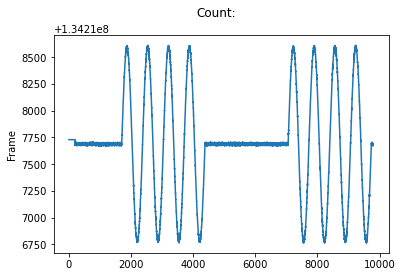

In [21]:
fig, axs = plt.subplots(1)
axs.plot(wav1)
plt.ylabel('Frame')
fig.suptitle('Count:')

maxAvg = np.max(wav1)
minAvg = np.min(wav1)
print ("Count:{0}, MSB Shift:{1}".format(AvgCount, AvgShiftMSB))
print("Max:{0}, Min:{1}, Delta:{2}".format(maxAvg,minAvg,maxAvg-minAvg))

### Normalize to Signed number 

In [22]:
def MsbCutoff(AvgCount):
    for i in range(31,14,-1):
      if ((1 << i) & AvgCount) != 0:
            break;
    log2FrameFactor = 1 << (i - 15);
    return log2FrameFactor;

Text(0.5, 0.98, 'Count:')

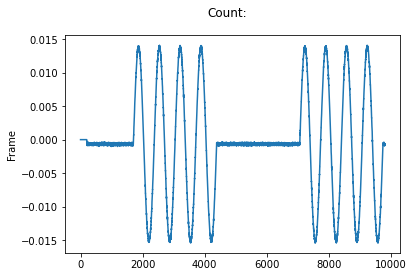

In [23]:
wavNorm = np.add(wav1, - np.power(2,27)) * MsbCutoff(AvgCount)/AvgCount

fig, axs = plt.subplots(1)
axs.plot(wavNorm)
plt.ylabel('Frame')
fig.suptitle('Count:')


In [24]:
inst.close_instrument()
#admin.close_inst_admin()